# ДЗ №6

## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

(250, 250, 3) tf.Tensor(b'Tom_Amstutz', shape=(), dtype=string)


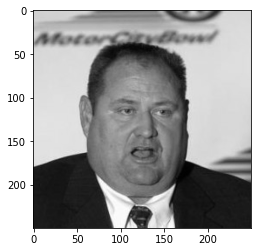

In [165]:
def normalize_img(label, image):
  image = tf.image.rgb_to_grayscale(image)
  image = tf.cast(image, tf.float32) / 255.
  return image, label

ds, info = tfds.load('lfw', split='train', as_supervised=True, with_info=True)

for label, image in ds.take(1):
  print(image.shape, label)
  image, label = normalize_img(label, image)
  plt.imshow(image[:,:,0], cmap='gray')

BATCH_SIZE = 128
TOTAL_SIZE = 13233
TEST_SIZE = TOTAL_SIZE // 4
TRAIN_SIZE = TOTAL_SIZE - TEST_SIZE 

test_ds = ds.skip(TRAIN_SIZE)
ds = ds.take(TRAIN_SIZE)

ds = ds.map(normalize_img)
ds = ds.shuffle(10)
ds = ds.repeat(NUM_EPOCHS)
ds = ds.batch(BATCH_SIZE)

test_ds = test_ds.map(normalize_img)

## Создание модели CNN

In [0]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [0]:
MARGIN = 20.0

def contastive_loss(embs, labels):
    bs = embs.shape[0] // 2

    embs1 = embs[:bs, :]
    embs2 = embs[bs:bs*2, :]
    labels1 = labels[:bs]
    labels2 = labels[bs:bs*2]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [169]:
%%time

for iteration, (images, labels) in enumerate(ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 10 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 385.14520263671875
[10] Loss: 2831.44482421875
[20] Loss: 20.575603485107422
[30] Loss: 0.00031109791598282754
[40] Loss: 0.18104876577854156
[50] Loss: 0.7318748235702515
[60] Loss: 0.0015228441916406155
[70] Loss: 0.46257007122039795
[80] Loss: 1.9511973857879639
[90] Loss: 0.6399403810501099
[100] Loss: 0.5667083263397217
[110] Loss: 0.6154091954231262
[120] Loss: 0.016584506258368492
[130] Loss: 0.0
[140] Loss: 2.2630951404571533
[150] Loss: 0.06188638508319855
[160] Loss: 4.859012126922607
[170] Loss: 0.562475860118866
[180] Loss: 0.19716988503932953
[190] Loss: 2.0228941440582275
[200] Loss: 0.5133742690086365
[210] Loss: 15.952796936035156
[220] Loss: 0.03703867271542549
[230] Loss: 0.05291788652539253
[240] Loss: 2.8421616554260254
[250] Loss: 1.3683034181594849
[260] Loss: 0.1512000560760498
[270] Loss: 0.6639666557312012
[280] Loss: 20.809640884399414
[290] Loss: 0.0
[300] Loss: 0.034728940576314926
[310] Loss: 0.654857873916626
CPU times: user 2min 56s, sys: 1min 1

## Получение эмбеддингов для тестовой выборки

In [0]:
test_x = None
test_y = []

for iteration, (images, labels) in enumerate(test_ds.batch(BATCH_SIZE)):
    embs = model(images)
    test_y += list(labels.numpy())

    if test_x is None:
        test_x = embs.numpy()
    else:
        test_x = np.vstack((test_x, embs.numpy()))

test_y = np.array(test_y)

from collections import Counter
cls = [i for i, _ in Counter(test_y).most_common(10)]

## Функция для визуализации эмбеддингов

In [0]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_x)

In [172]:
print(cls[0])
test_embs_2D[test_y == cls[0], :]

b'George_W_Bush'


array([[ 54.35815  ,  21.911589 ],
       [-16.991903 ,  36.864864 ],
       [-23.692152 , -35.723526 ],
       [ -6.384868 ,   2.8319173],
       [ 55.038998 , -17.515192 ],
       [-14.094491 , -41.22208  ],
       [ -4.3129683, -44.756023 ],
       [ 53.732254 , -22.515259 ],
       [-36.82445  , -13.155911 ],
       [  9.819157 , -37.138676 ],
       [ 57.255817 , -16.804354 ],
       [-12.587557 ,  26.106573 ],
       [ 29.751553 ,  37.29398  ],
       [ 29.839382 , -21.075619 ],
       [ 18.644878 ,  -3.3509195],
       [ 26.806652 , -23.111212 ],
       [ 50.768238 , -20.74871  ],
       [ 20.461935 ,   6.365147 ],
       [-37.38967  , -36.437798 ],
       [ 49.928223 ,  -2.799154 ],
       [  8.557747 , -59.010597 ],
       [-32.43967  , -36.65013  ],
       [ 33.499607 , -20.873287 ],
       [-35.006107 , -17.437765 ],
       [ 57.72612  ,   6.390332 ],
       [  6.874833 , -11.482001 ],
       [ 23.989841 ,  32.91157  ],
       [  3.3573427,  22.603012 ],
       [-53.69148  ,

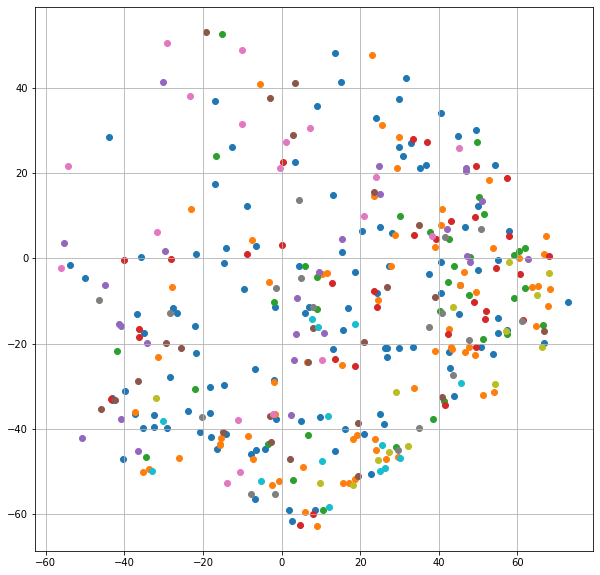

In [173]:
plt.figure(figsize=(10, 10))
for cl in cls:
    X_embedded_class = test_embs_2D[test_y == cl, :]
    plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
plt.grid(True)

## Тестирование на новых данных

In [0]:
!wget https://ca-times.brightspotcdn.com/dims4/default/37458e8/2147483647/strip/true/crop/1024x575+0+0/resize/840x472!/quality/90/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2Fbe%2F98%2Fbc9460e2951e06c21c77c20ea7c5%2Fsd-ahamblin-1485896120-snap-photo -O 1.jpg
!wget https://s.abcnews.com/images/US/george-w-bush-file-gty-jef-200403_hpMain_16x9_992.jpg -O 2.jpg
!wget https://thumbor.forbes.com/thumbor/fit-in/416x416/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fimageserve%2F5babef3da7ea4342a948c024%2F0x0.jpg%3Fbackground%3D000000%26cropX1%3D1314%26cropX2%3D2845%26cropY1%3D222%26cropY2%3D1752 -O 3.jpg

In [0]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250), order=3, mode='reflect', anti_aliasing=True)

    img, _ = normalize_img(None, img)
    return img

img_a1 = load_and_prepare_image('1.jpg')
img_a2 = load_and_prepare_image('2.jpg')
img_b1 = load_and_prepare_image('3.jpg')

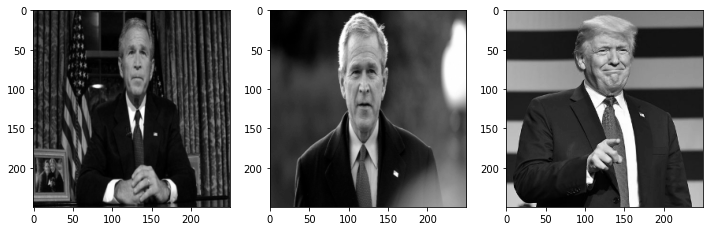

In [182]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1[:,:,0], cmap='gray')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2[:,:,0], cmap='gray')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1[:,:,0], cmap='gray')
plt.show()

## Получение эмбеддингов для новых данных

In [0]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

## Вычисление расстояний между эмбеддингами

In [184]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  0.16386980138792256
A2 <-> B1:  0.09056152883447273
A1 <-> B1:  0.18514697498317095


# ВЫВОД

Нужна либо другая конфигурация сети или нужно получше обучить ее, пока что  работает очень плохо